In [16]:
# highs['hour'] = [f"{str(x)[-8:-6]}h UTC" for x in highs.index]
# byhour = highs.groupby('hour').count().sort_values(by='hour')
# plot(plt.bar, byhour, ['open'], ['g'], is_date=False)

In [17]:
import os

os.chdir('/home/tom/Workspace/hypeminer/misc/optimisation')
# os.chdir('C:/Users/Agando/Workspace/hypeminer/misc/optimisation')

In [98]:
import json
import pandas as pd
from datetime import datetime
from IPython.display import display
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.style.use('ggplot')

symbol = 'BNBBUSD'
freq = 5

start_train = '20210101000000'
days_train = 90

start_test = '20210401000000'
days_test = 30

WINDOW = 100

strategy = 'StockPerceptron'
strategy_name = 'Self-Supervised Stock Perceptron'

# ---------------------------------------------------------

FEES = 0.0012

def to_datetime(timestamp):
    return datetime(
      int(timestamp[0:4]), int(timestamp[4:6]), int(timestamp[6:8]), 
      int(timestamp[8:10]), int(timestamp[10:12]), int(timestamp[12:14])
  )

def load_file(file):
    with open(file) as f:
        data = json.load(f)
    index = [datetime.strptime(v['timestamp'], '%Y-%m-%d %H:%M:%S') for v in data]
    df = pd.DataFrame(index=index)
    for field in ['open', 'high', 'low', 'close', 'volume', 'trades']:
        df[field] = [v[field] for v in data]
    return df

def display_whole(dframe):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(dframe)

# run_id = f"{symbol}-{start}-{freq}-{days}-{strategy}"
# run_title = f"{symbol} - {strategy_name} at {days} days from " \
#             f"{to_datetime(start).strftime('%Y-%m-%d')} every {freq} minutes"
# file = f"{symbol}-{start}-{freq}-{days}.json"

to_interval = {
    1: '1m',
    3: '3m',
    5: '5m',
    15: '15m',
    30: '30m',
    60: '1h',
    120: '2h',
    240: '4h',
    360: '6h',
    480: '8h',
    720: '12h',
    1440: '1d',
    4320: '3d',
    10080: '1w',
}

def to_epoch(timestamp, milliseconds=True):
    dt = to_datetime(timestamp)
    epoch = dt.timestamp()
    if milliseconds:
        return int(epoch * 1000)
    else:
        return int(epoch)
    
def to_readable(epoch):
    return datetime.fromtimestamp(epoch/1000).strftime('%Y-%m-%d %H:%M:%S')

def plot(plt_fun, df_plot, cols, colours, title=None, baseline=None, is_date=True):
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.clf()
    if is_date:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    assert len(cols) == len(colours)
    for col, clr in zip(cols, colours):
        plt_fun(df_plot.index, df_plot[col], color=clr, label=col)
    if baseline:
        try:
            for bl in baseline:
                plt.axhline(y=bl, color='b', linestyle='-', label='baseline')
        except:
            plt.axhline(y=baseline, color='b', linestyle='-', label='baseline')
    plt.legend(loc="best", prop={'size': 12})
    if not title:
        title = f"{symbol} - freq={freq}"
    plt.title(title)
    plt.gcf().autofmt_xdate()

BINANCE_URL = "https://api.binance.com/api/v3/klines?symbol={}&interval={}&limit={}&startTime={}"

def fetch(symbol, epoch, interval="1m", limit=1):
    url = BINANCE_URL.format(symbol, interval, limit, epoch)
    response = requests.request("GET", url)
    result = json.loads(response.text)
    print(url)
    return result
    
def download_history_fast(symbol, start, freq=60, days=90):
    millis_in_period = days * 24 * 60 * 60 * 1000
    file_dest = f"{symbol}-{start}-{freq}-{days}.json"
    if os.path.isfile(file_dest):
        print(f"File {file_dest} found.")
        return
    epoch = to_epoch(start)
    epoch_at_start = epoch
    interval = to_interval[freq]
    values = []
    i = 0
    completed = False
    while not completed:
        values_batch = fetch(symbol, epoch, interval=interval, limit=1000)
        for value in values_batch:
            obj = {"index": len(values), "epoch": value[0], "timestamp": to_readable(value[0]), "open": float(value[1]), 
                   "high": float(value[2]), "low": float(value[3]), "close": float(value[4]), "volume": float(value[5]), 
                   "trades": value[8]}
            values.append(obj)
            if value[0] >= epoch_at_start + millis_in_period:
                completed = True
                break
        print(f"Fetched {len(values)} values at {to_readable(epoch)}...")
        epoch = values[-1]["epoch"] + freq * 60000

    with open(file_dest, 'w') as f_out:
        json.dump(values, f_out)

In [19]:
download_history_fast(symbol, start_train, freq=freq, days=days_train)
df_train = load_file(f"{symbol}-{start_train}-{freq}-{days_train}.json")

download_history_fast(symbol, start_test, freq=freq, days=days_test)
df_test = load_file(f"{symbol}-{start_test}-{freq}-{days_test}.json")

In [20]:
def simulate(df):
    df['action'] = None
    df['prev_open'] = df['open'].shift(1)
    df['stake'] = None
    df['prev_stake'] = None

    invested = False
    for i, (index, row) in enumerate(df.iterrows()):
        df.loc[index, 'prev_stake'] = df['stake'].iloc[i-1] if i > 0 else 1
        # stake accrued
        if invested:
            df.loc[index, 'stake'] = df.loc[index, 'prev_stake'] / row['prev_open'] * row['open']
        else:
            df.loc[index, 'stake'] = df.loc[index, 'prev_stake']
        # follow action
        if row['is_low'] and not invested:
            df.loc[index, 'action'] = 'BUY'
            df.loc[index, 'stake'] = df.loc[index, 'stake'] * (1 - FEES)
            invested = True
        elif row['is_high'] and invested:
            df.loc[index, 'action'] = 'SELL'
            df.loc[index, 'stake'] = df.loc[index, 'stake'] * (1 - FEES)
            invested = False
        else:
            df.loc[index, 'action'] = '----'

    del df['prev_open']
    del df['prev_stake']
    
    return df

In [21]:
def idx_max(df_arg):
    return df_arg.index.values[np.argmax(df_arg.values)]
def idx_min(df_arg):
    return df_arg.index.values[np.argmin(df_arg.values)]

IDX_FUN = {'max': idx_max, 'min': idx_min}

# TODO improvement: give a score in [0,1] for is_high and is_low based on price
# TODO improvement: compute the maximum between each local minimum and its next one
def find_extrema(arg_type, dframe, y, window):
    y_arg = f"{y}_arg{arg_type}"
    idx = IDX_FUN[arg_type]
    temp = dframe[y].rolling(window=window, min_periods=int(window/2)).agg([idx])
    dframe[y_arg] = pd.to_datetime(temp[idx.__name__])
    ext = dframe.groupby(y_arg).count().sort_values(by=y, ascending=False)
    del dframe[y_arg]
    return ext[ext[y] == window]

def self_supervised_annotation(df):
    highs = find_extrema('max', df, 'open', WINDOW)
    lows = find_extrema('min', df, 'open', WINDOW)

    highs['high_opens'] = 0
    df['is_high'] = False
    for index, row in highs.iterrows():
        highs.loc[index, 'high_opens'] = df.loc[index]['open']
        df.loc[index, 'is_high'] = True

    lows['low_opens'] = 0
    df['is_low'] = False
    for index, row in lows.iterrows():
        lows.loc[index, 'low_opens'] = df.loc[index]['open']
        df.loc[index, 'is_low'] = True

def self_supervised_annotation_two(df):
    df['open_prev'] = df['open'].shift(1)
    df['open_next'] = df['open'].shift(-1)

    df['is_high'] = (df['open_prev'] < df['open']) & (df['open'] > df['open_next'])
    df['is_low'] = (df['open_prev'] > df['open']) & (df['open'] < df['open_next'])

    df = df.iloc[1:-1].copy() # trim

    del df['open_prev'], df['open_next']
    
# self_supervised_annotation(df_train)
# self_supervised_annotation(df_test)

self_supervised_annotation_two(df_train)
self_supervised_annotation_two(df_test)

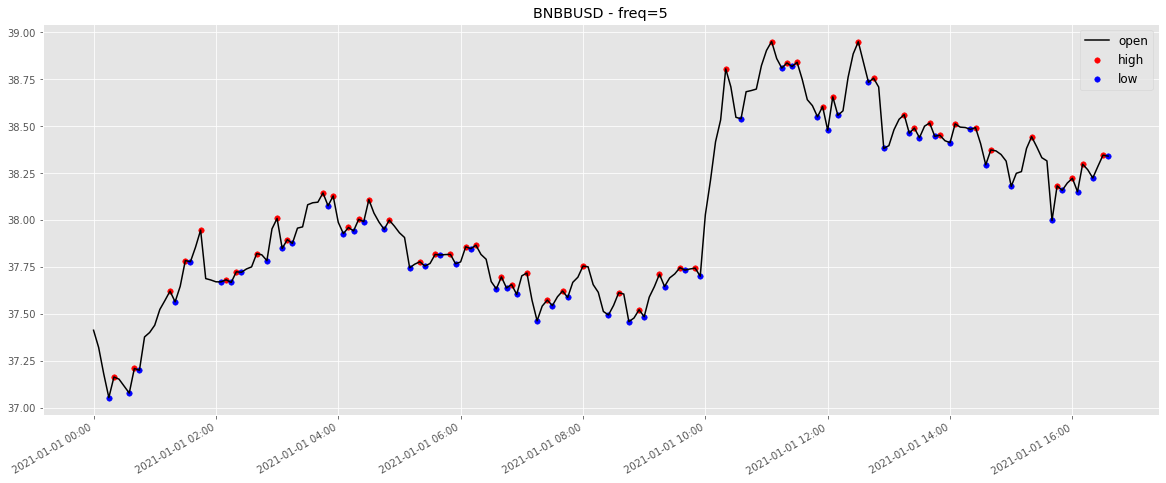

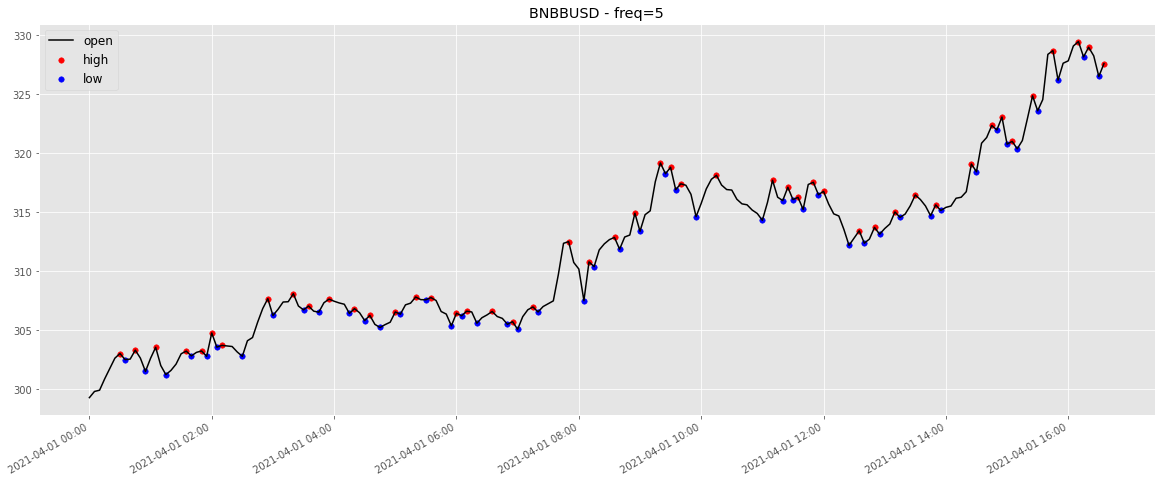

In [22]:
# ---- outputs ----
def output_chart(df, displ=False, tsv_id=None):
    df_plot = df.copy()
    
    pts = int(len(df_plot)/3000) if len(df_plot) > 3000 else 1

    highs = df_plot[df_plot['is_high']]
    lows = df_plot[df_plot['is_low']]
    
    plot(plt.plot, df.iloc[::pts, :], ['open'], ['k'])
    plt.scatter(highs.index, highs['open'], c='r', marker='.', s=120, label='high')
    plt.scatter(lows.index, lows['open'], c='b', marker='.', s=120, label='low')
    plt.legend(loc="best", prop={'size': 12})
    plt.show()
    
    if displ:
        display_whole(df_plot[df_plot['action'] != '----'])
    if tsv_id:
        df.to_csv(f"{tsv_id}.tsv", sep='\t')

output_chart(df_train.iloc[:200])
output_chart(df_test.iloc[:200])

In [23]:
def theoretical_maximum_stake(df, displ=False):
    print(f"Simulating with {len(df)} datapoints...")
    df_train_sim = simulate(df)
    if displ:
        display_whole(df[df['action'] != '----'][['open', 'action', 'stake']])
    return {'stake': round(df['stake'].iloc[-1], 2), 'hold': round(df['open'].iloc[-1] / df['open'].iloc[0], 2)}

thmstake = {'train': theoretical_maximum_stake(df_train), 'test': theoretical_maximum_stake(df_test)}
print(f"Theoretical maximum stake: {thmstake}")

Simulating with 25888 datapoints...
Simulating with 8555 datapoints...
Theoretical maximum stake: {'train': {'stake': 1222644979956.69, 'hold': 8.09}, 'test': {'stake': 18912.72, 'hold': 2.07}}


In [24]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def rsi(data, n):
    # Make the positive gains (up) and negative gains (down) Series
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up1 = up.ewm(span=n).mean()
    roll_down1 = down.abs().ewm(span=n).mean()

    # Calculate the RSI based on EWMA
    rs1 = roll_up1 / roll_down1
    return 100.0 - (100.0 / (1.0 + rs1))

def get_oscillator(data, field):
    win_50 = data[field].rolling(window=50)
    max_volume = win_50.max()
    min_volume = win_50.min()
    return 100.0 * (data[field] - min_volume) / (max_volume - min_volume)

def technical_analysis(df):
    df['change_norm'] = 100.0 * df['open'].diff() / df['open'].shift(1)

    df['ma50'] = df['open'].rolling(window=50).mean()

    df['ema12'] = ema(df['open'], 12)
    df['ema26'] = ema(df['open'], 26)
    df['macd'] = df['ema12'] - df['ema26']
    df['signal'] = ema(df['macd'], 9)
    df['macd_histo'] = df['macd'] - df['signal']
    df['macd_histo_diff'] = df['macd_histo'].diff()

    boll = df['open'].rolling(window=20)
    boll_2std = 2.0 * boll.std()
    df['bollinger_low'] = boll.mean() - boll_2std
    df['bollinger_mid'] = boll.mean()
    df['bollinger_high'] = boll.mean() + boll_2std
    del boll, boll_2std

    df['rsi14'] = rsi(df['open'], 14)

    low5 = df['low'].rolling(window=5).min()
    df['rsv'] = 100.0 * (df['open'] - low5) / (df['high'].rolling(window=5).max() - low5)
    del low5
    df.loc[df['rsv'].isnull(), 'rsv'] = 50 # when max=min, the RSV is halfway up
    df['kdj_k'] = df['rsv'].rolling(window=3).mean()
    df['kdj_d'] = df['kdj_k'].rolling(window=3).mean()
    df['kdj_j'] = 3.0 * df['kdj_k'] - 2.0 * df['kdj_d']

    df['kdj_osc'] = 100.0 - abs(df['kdj_k'] - df['kdj_d']) # crosses at 99-100

    df['volume_ma3'] = df['volume'].rolling(window=3).sum() # accumulated volumes
    df['volume_osc'] = get_oscillator(df, 'volume')
    df['volume_ma3_osc'] = get_oscillator(df, 'volume_ma3')

    df['trades_ma3'] = df['trades'].rolling(window=3).sum() # accumulated trades
    df['trades_osc'] = get_oscillator(df, 'trades')
    df['trades_ma3_osc'] = get_oscillator(df, 'trades_ma3')

    df['bollinger_low_norm'] = 200.0 - 100.0 * df['low'] / df['bollinger_low'] # breaks above 100
    df['bollinger_high_norm'] = 100.0 * df['high'] / df['bollinger_high']      # breaks above 100

    df['macd_histo_norm'] = 100000.0 * df['macd_histo'] / df['ma50'] / freq    # ideally in [-100, +100]
    df['macd_histo_norm_diff'] = df['macd_histo_norm'].diff()
    
    
technical_analysis(df_train)
technical_analysis(df_test)

In [90]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support
from sklearn.utils import resample
import joblib


feature_columns = [
    'change_norm', 'rsi14', 'rsv', 'kdj_k', 'kdj_d', 'kdj_j', 'kdj_osc', 'volume_osc', 'volume_ma3_osc', 
    'trades_osc', 'trades_ma3_osc', 'bollinger_low_norm', 'bollinger_high_norm', 'macd_histo_norm', 'macd_histo_norm_diff',
]
column_with_latest_null = 'volume_ma3_osc'

# from sklearn.neural_network import MLPClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import GridSearchCV, ShuffleSplit

# X,y = make_classification(n_samples=100000)
# mlp = MLPClassifier()

# grid = GridSearchCV(mlp, {}, n_jobs=1, cv=ShuffleSplit(n_splits=1),
#                     verbose=2)
# grid.fit(X,y)

def upsample_dataset(df, y_col, rate=1.0, values=[False, True]):
    # Separate majority and minority classes
    df_majority = df[df[y_col] == values[0]]
    df_minority = df[df[y_col] == values[1]]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=int(rate*len(df_majority)),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print(f"New upsampled counts:\n{df_upsampled[y_col].value_counts()}")
    
    return df_upsampled

def to_features(df, X_cols, y_col):
    
    df_not_null = df[df[column_with_latest_null].notnull()].copy()
    
    # watch for null values
    for x_col in X_cols:
        assert len(df_not_null[df_not_null[x_col].isnull()]) == 0

    return df_not_null[X_cols].copy(), [float(v) for v in df_not_null[y_col]]

def train(df, X_cols, y_col, upsample_rate=1.0):
    
    df = upsample_dataset(df, y_col, rate=upsample_rate)
    
    X, y = to_features(df, X_cols, y_col)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=1)
    
    clf = MLPClassifier(random_state=1, 
                        max_iter=500,
                        learning_rate_init=0.01,
#                         momentum=None,
#                         validation_fraction=None
                       ).fit(X_train, y_train)
    return {'model': clf, 'X_train': X_train, 'X_valid': X_valid, 'y_train': y_train, 'y_valid': y_valid}

def load_results(file):
    return joblib.load(file)

def do_training(confusion_matrix=False, upsample_rate=1.0, save=True):
    file = f"{symbol}-{start_train}-{freq}-{days_train}-{strategy}.dat"
    if os.path.isfile(file):
        print(f"File {file} found.")
        return load_results(file)
    results = {}
    for cls in ['is_high', 'is_low']:
        print(f"Training {cls} model...")
        result = train(df_train, feature_columns, cls, upsample_rate=upsample_rate)

        raw_acc = result['model'].score(result['X_valid'], result['y_valid'])
        y_pred = result['model'].predict(result['X_valid'])
        f1 = f1_score(result['y_valid'], y_pred)
        print(f"Raw accuracy: {raw_acc:.3f}")
        print(f"F-Score: {f1:.3f}")

        if confusion_matrix:
            plt.rcParams["figure.figsize"] = (10, 4)
            plot_confusion_matrix(result['model'], result['X_valid'], result['y_valid'], 
                                      display_labels=["False", "True"])
            plt.grid(False)
            plt.title(f"{cls} Model Confusion Matrix")
            plt.show()
        
        print()
        
        results[cls] = result
    
    if save:
        joblib.dump(results, file)
    
    return results

upsr = 1.0
results = do_training(upsample_rate=upsr)

File BNBBUSD-20210101000000-5-90-Patterns.dat found.


In [35]:
def show_predictions(result):
    for y_hat, prob, y in zip(result['model'].predict(result['X_test']), 
                              result['model'].predict_proba(result['X_test']), 
                              result['y_test']):
        print(f"{y_hat}\t{prob}\t{y}".expandtabs(20))

# show_predictions(results['is_high'])

Model: is_high
Raw accuracy: 0.808
F-Score: 0.459
Precision: 0.830
Recall: 0.317

Model: is_low
Raw accuracy: 0.823
F-Score: 0.462
Precision: 0.868
Recall: 0.315



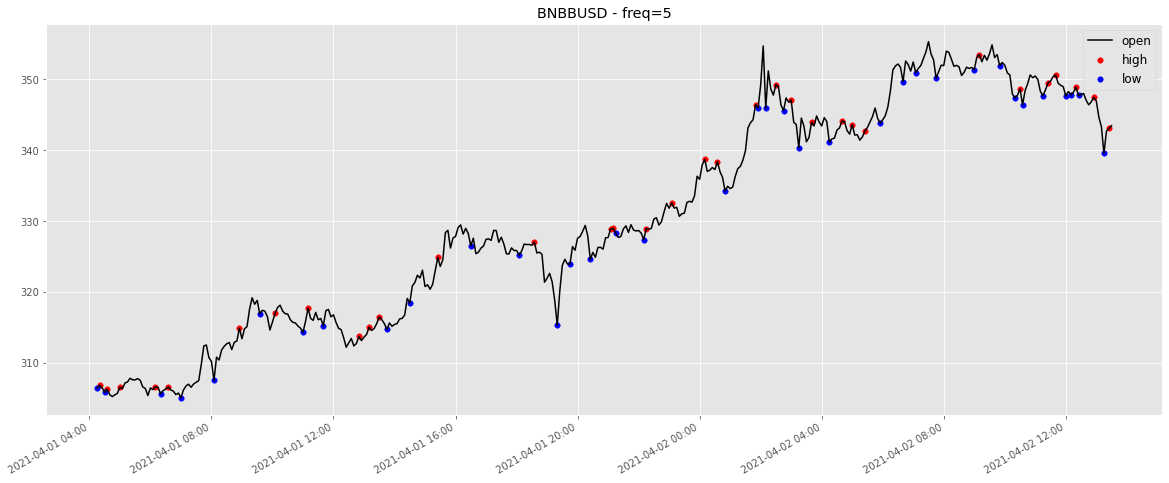

Simulating with 8504 datapoints...
{'stake': 7.23, 'hold': 2.02}


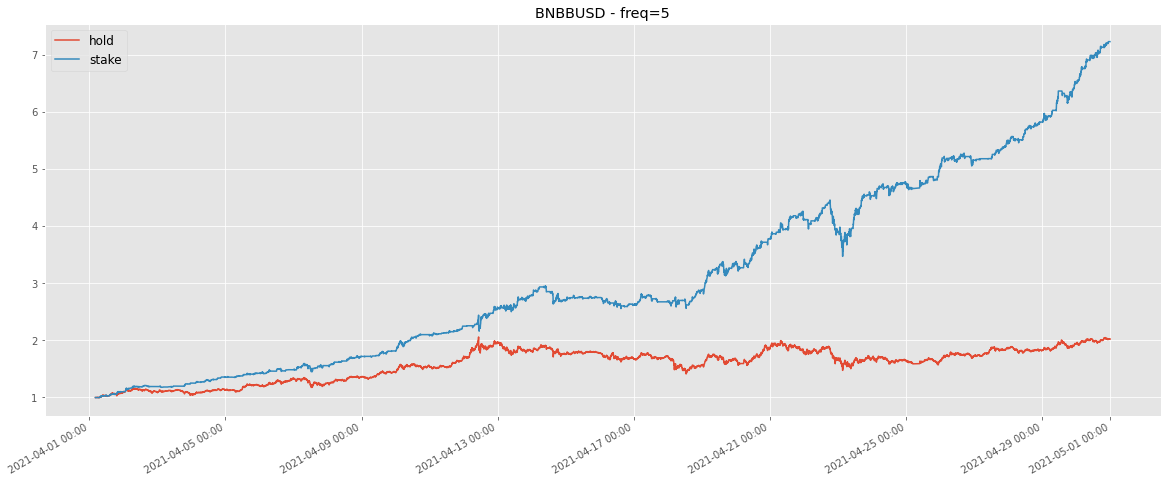

In [100]:
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support

THRESHOLD = 0.85

def show_simulation(df_plot):
    df_plot['hold'] = df_plot['open'] / df_plot['open'].iloc[0]
    plot(plt.plot, df_plot, ['hold', 'stake'], [None, None])

def predict_and_show(df_test, pred_id):
    for cls in ['is_high', 'is_low']:
        X_test, y_test = to_features(df_test, feature_columns, cls)
        y_prob = results[cls]['model'].predict_proba(X_test)
        y_pred = []
        for y_p in y_prob:
            y_pred.append(1 if y_p[1] > THRESHOLD else 0)
        raw_acc = results[cls]['model'].score(X_test, y_test)
        pr, f1 = precision_recall_fscore_support(y_test, y_pred), f1_score(y_test, y_pred)
        print(f"Model: {cls}")
        print(f"Raw accuracy: {raw_acc:.3f}")
        print(f"F-Score: {f1:.3f}")
        print(f"Precision: {list(pr[0])[1]:.3f}")
        print(f"Recall: {list(pr[1])[1]:.3f}\n")
        results[cls][f'X_{pred_id}'] = X_test
        results[cls][f'y_{pred_id}'] = y_test
        results[cls][f'y_{pred_id}_pred'] = y_pred

    df_test_pred = df_test[df_test[column_with_latest_null].notnull()].copy()
    for cls in ['is_high', 'is_low']:
        df_test_pred[cls] = [bool(x) for x in results[cls][f'y_{pred_id}_pred']]
    output_chart(df_test_pred.iloc[:400])

    print(theoretical_maximum_stake(df_test_pred))

    show_simulation(df_test_pred)
    
predict_and_show(df_test, 'test')

## Stable coin environment

File BNBBUSD-20210412000000-5-16.json found.


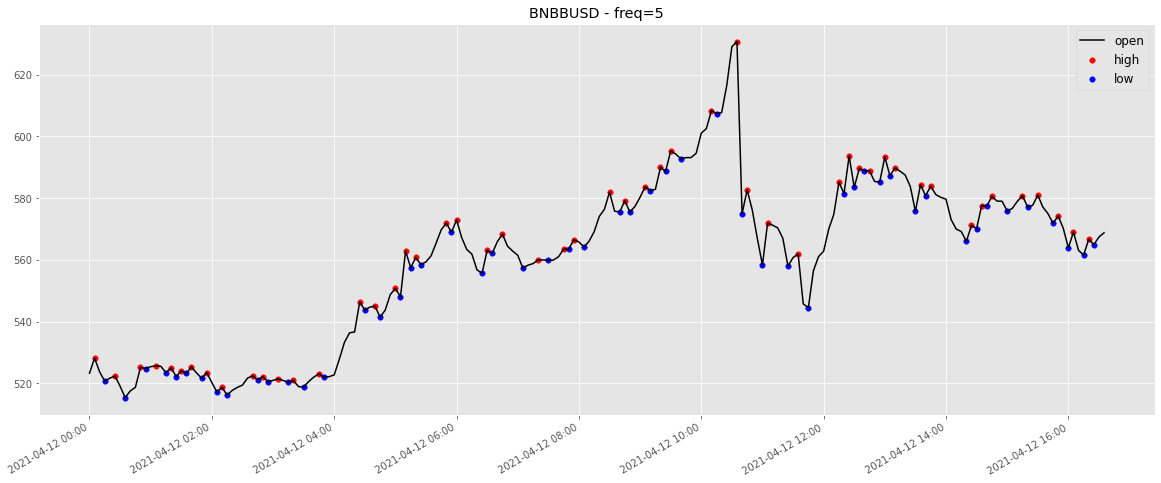

Simulating with 4523 datapoints...
Theoretical maximum stake: {'stake': 537.21, 'hold': 1.09}

Model: is_high
Raw accuracy: 0.818
F-Score: 0.437
Precision: 0.823
Recall: 0.298

Model: is_low
Raw accuracy: 0.818
F-Score: 0.481
Precision: 0.833
Recall: 0.338



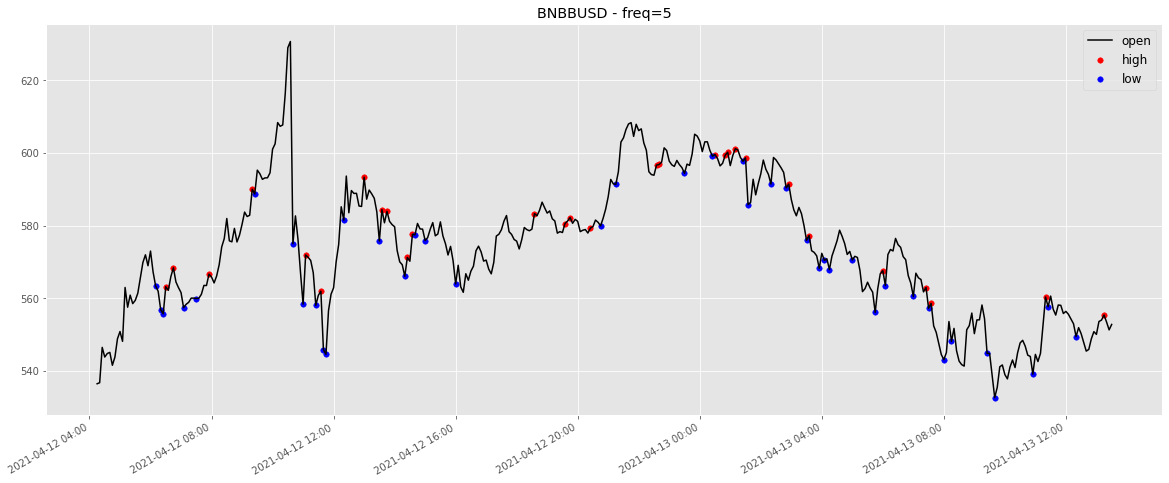

Simulating with 4472 datapoints...
{'stake': 2.42, 'hold': 1.06}


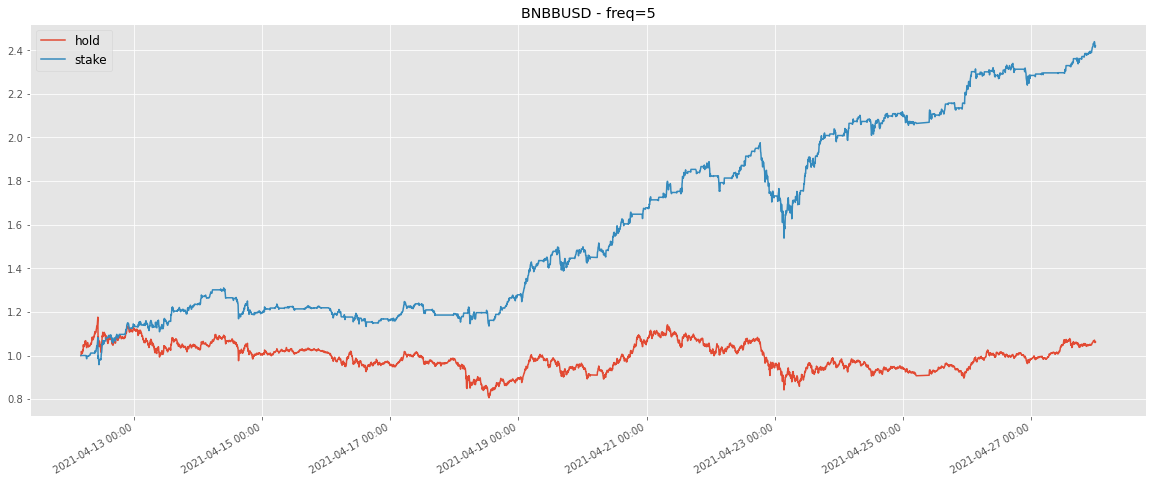

In [101]:
start_stable = '20210412000000'
days_stable = 16

download_history_fast(symbol, start_stable, freq=freq, days=days_stable)
df_stable = load_file(f"{symbol}-{start_stable}-{freq}-{days_stable}.json")

self_supervised_annotation_two(df_stable)
output_chart(df_stable.iloc[:200])
print(f"Theoretical maximum stake: {theoretical_maximum_stake(df_stable)}\n")
technical_analysis(df_stable)
results = load_results(f"{symbol}-{start_train}-{freq}-{days_train}-{strategy}.dat")
predict_and_show(df_stable, 'stable')

In [27]:
# df_test = pd.read_csv(f"weka/test_dataset_is_high.csv") # is_low is identical

# sampling = 'downsampling-at-2' # 'balancing' # 'upsampling' # 

# # ---- Weka models ----
# for cls in ['is_high', 'is_low']:
#     df_pred = pd.read_csv(f"weka/{sampling}/predictions_{cls}.csv")
#     df_test[cls] = (df_pred['predicted'] == '2:True') & (df_pred['prediction'] == 1)

# # TODO delete the positives that aren't min/max within past WINDOW/2
    
# # ---- Using RSI only ----
# # df_test['is_high'] = (df_test['rsi14'] > 80) & (df_test['bollinger_high_norm'] > 101) & (df_test['macd_histo_norm_diff'] > 0)
# # df_test['is_low'] = (df_test['rsi14'] < 20) & (df_test['bollinger_low_norm'] > 101) & (df_test['macd_histo_norm_diff'] < 0)

# # ---- MACD Diff ----
# # df_test['is_high'] = (df_test['macd_histo_norm'] > 0) & (df_test['macd_histo_norm_diff'] < 0)
# # df_test['is_low'] = (df_test['macd_histo_norm'] < 0) & (df_test['macd_histo_norm_diff'] > 0)

# df_test[df_test['is_high'] | df_test['is_low']]

In [28]:
# FIRST_N_SAMPLES = 2000

# df_plot = df[df['volume_ma3_osc'].notnull()].copy()
# df_plot['is_high'] = list(df_test['is_high'])
# df_plot['is_low'] = list(df_test['is_low'])

# # df_plot = df_plot.iloc[:FIRST_N_SAMPLES].copy()

# highs = df_plot[df_plot['is_high']]
# lows = df_plot[df_plot['is_low']]

# pts = int(len(df_plot)/3000) if len(df_plot) > 3000 else 1

# plot(plt.plot, df_plot.iloc[::pts, :], ['open'], ['k'])
# plt.scatter(highs.index, highs['open'], c='r', marker='v', s=120, label='high')
# plt.scatter(lows.index, lows['open'], c='b', marker='^', s=120, label='low')
# plt.legend(loc="best", prop={'size': 12})

In [29]:
# df_plot = simulate(df_plot)

# display_whole(df_plot[df_plot['action'] != '----'][['open', 'action', 'stake']])

In [ ]:
# close_max, close_min = df.iloc[:100]['close'].max(), df.iloc[:100]['close'].min()
# close_den = close_max - close_min
# print(close_max, close_min, close_den)
# df['close_norm'] = 100 + 100 * (df['close'] - close_min) / close_den

# TODO

* extend the training set to 2019-2021
* use `../../hypeminer/data/BTCBUSD/datasets/store-indices.tsv`
* add price as % in `[min, max]`
* is_high and is_low points should allow a range of almost-high and almost-low values
* add BTC price as feature
* use https://www.tensorflow.org/tutorials/structured_data/time_series
* use https://stackoverflow.com/a/50836425/796157 for self-supervision

## Neural traders

* https://www.sciencedirect.com/science/article/pii/S1877050917318252
* https://www.turtletrader.com/neural/
* https://www.indiehackers.com/interview/building-a-3-500-mo-neural-net-for-trading-as-a-side-project-5dda352c13
* https://try.neuroshell.com/index/
* http://www.modulusfe.com/products/trading-system-developer-components/neural-trader-neural-network/
* https://www.investopedia.com/articles/trading/06/neuralnetworks.asp